<img src="images/rl.jpg" align=right width=50%></img>
# Reinforcement Learning
Author: Jin Yeom (jinyeom@utexas.edu)

## Contents
- [Reinforcement learning](#Reinforcement-learning)
    - [TD-learning](#TD-learning)
    - [Q-learning](#Q-learning)
    - [REINFORCE](#REINFORCE)
    - [Actor-critic](#Actor-critic)
- [Deep reinforcement learning](#Deep-reinforcement-learning)
    - [Trust-Region Policy Optimization (TRPO)](#Trust-Region-Policy-Optimization-%28TRPO%29)
    - [Proximal Policy Optimization (PPO)](#Proximal-Policy-Optimization-%28PPO%29)
    - [Deep Deterministic Policy Gradient (DDPG)](#Deep-Deterministic-Policy-Gradient-%28DDPG%29)
    - [Twin Delayed DDPG (TD3)](#Twin-Delayed-DDPG-%28TD3%29)
    - [Soft Actor-Critic (SAC)](#Soft-Actor-Critic-%28SAC%29)
- [References](#References)

**Note**: this notebook first covers basics and fundamentals of [reinforcement learning](https://en.wikipedia.org/wiki/Reinforcement_learning). Then, we will address more advanced deep reinforcement learning algorithms, where deep networks are used as a function approximator. For the latter, we will follow the curriculum provided by OpenAI's [Spinning Up in Deep RL](https://blog.openai.com/spinning-up-in-deep-rl/). This means that we will omit tricks (e.g., observation normalization) and only focus on the core functionalities.

In [1]:
import gym
import numpy as np
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import torch
from torch import nn, optim, distributions
from torch.nn import functional as F
from torchsummary import summary
from IPython import display

In [2]:
%matplotlib notebook

np.random.seed(23)
torch.manual_seed(23)

## Reinforcement learning

### TD-learning

Invented by Arthur Samuel (who supposedly coined the term "machine learning"!), Temporal difference learning (**TD-learning**) is a class of reinforcement learning methods that learn by bootstrapping from the current estimate of the value function. TD value learning seems to be the most minimal embodiment of the most fundamental concept in reinforcement learning, which is **maximization of expected sum of rewards**. The learning rule is described as follows,

$$
V(s_t) \leftarrow (1 - \alpha)V(s_t) + \alpha(r_t + \gamma V(s_{t + 1}))
$$

which can also be written as 

$$
V(s_t) \leftarrow V(s_t) + \alpha(r_t + \gamma V(s_{t + 1}) - V(s_t))
$$

where $r_t + \gamma V(s_{t + 1})$ is the *TD target* and $r_t + \gamma V(s_{t + 1}) - V(s_t)$ is the *TD error*.

Note: I also want to emphasize that TD-learning is a *class* of learning algorithms, even though we use the term here for referring to learning the value function. In other words, other temporal difference methods such as Q-learning, SARSA, and TD-$\lambda$ are all TD-learning methods.

### Q-learning

Temporal-difference value function learning suggests a nice approach to evaluate a given policy $\pi$, but it's useless in most practical cases, as it provides no information on what action should be taken at a state without a transition function (**Note**: with a transition function $T(s_t, a, s_{t+1})$ provided, an optimal policy can be learned via a method called *Value Iteration*).

**Q-learning** is a TD-learning method that learns the action-value function, $Q(S, A)$, rather than the state-value function, $V(S)$. In such way, the agent can decide *which action to take*, without having to know the transition model. The learning rule is as follows,

$$
Q(s_t, a_t) \leftarrow (1 - \alpha)Q(s_t, a_t) + \alpha(r_t + \gamma \max_{a}Q(s_{t + 1}, a))
$$

which, once again, can be rewritten as

$$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha(r_t + \gamma \max_{a}Q(s_{t + 1}, a) - Q(s_t, a_t))
$$

where the term $r_t + \gamma \max_{a}Q(s_{t + 1}, a) - Q(s_t, a_t)$ directly describes the "error" in Q values.

In [3]:
def update_q(q_table, obs, action, reward, next_obs, alpha, gamma):
    diff = reward + gamma * np.max(q_table[next_obs, :]) - q_table[obs, action]
    q_table[obs, action] = q_table[obs, action] + alpha * diff

In [4]:
def q_learning(q_table, env, alpha, gamma, epsilon, n_iters, n_eps):
    ep_log = [] # record length and total reward of each episode
    for ep in tqdm(range(n_eps)):
        obs = env.reset()
        i = total_reward = done = 0
        while not done and i < n_iters:
            # ε-greedy is applied for exploration, in which by some probability ε,
            # a random action is chosen, instead of the reward maximizing action.
            action = np.random.choice(
                [env.action_space.sample(), np.argmax(q_table[obs, :])], 
                p=[epsilon, 1 - epsilon])
            next_obs, reward, done, _ = env.step(action)
            update_q(q_table, obs, action, reward, next_obs, alpha, gamma)
            total_reward += reward
            obs = next_obs
            i += 1
        ep_log.append((i, total_reward))
    return ep_log

For this section, we're going to use a simple Grid World based environment called **Taxi-v2** from OpenAI Gym.

In [5]:
env = gym.make("Taxi-v2")
print(env.observation_space)
print(env.action_space)

Discrete(500)
Discrete(6)


In [6]:
q_table = np.zeros((env.observation_space.n, env.action_space.n))
ep_log = q_learning(q_table, env, 0.1, 0.9, 0.2, 200, 2000)
durations, total_rewards = zip(*ep_log)

<IPython.core.display.Javascript object>


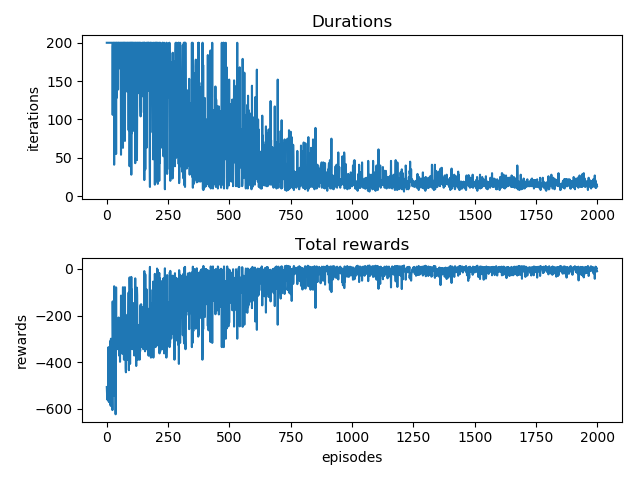

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.set_title("Durations")
ax1.set_ylabel("iterations")
ax1.plot(durations)

ax2.set_title("Total rewards")
ax2.set_ylabel("rewards")
ax2.plot(total_rewards)

plt.xlabel("episodes")
plt.tight_layout()
plt.show()

In [8]:
obs = env.reset()
done = False
while not done:
    env.render()
    action = np.argmax(q_table[obs, :])
    obs, reward, done, info = env.step(action)

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | :_:G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : :_: |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : :_: : |
| : : : : |
| | : | : |
|Y| : |B: |

That was fun and all, but Q-learning (or even its [deep learning varient from DeepMind](https://deepmind.com/research/dqn/), which is explored in a different notebook) turned out to be not so useful by itself, as it cannot scale with continuous problems (**Note**: this isn't true in reality: there are deep RL algorithms that address this issue; we'll get to that). Policy optimization, which optimizes the agent's policy directly, is an alternative for such purposes. There are several classes of policy optimization methods, including [evolutionary algorithms](https://blog.openai.com/evolution-strategies/), but in this notebook, we'll focus on gradient-based methods, namely **policy gradient** methods.

### REINFORCE

Among various policy gradient methods, **REINFORCE** (***RE***ward ***I***ncrement = ***N***onnegative ***F***actor times ***O***ffset ***R***einforcement times ***C***haracter ***E***ligibility; *I know, may this terrible acronym never come up again*), is the most naive. The core idea of this algorithm is the following update rule:

$$
\theta_{t + 1} \leftarrow \theta_t + \alpha \gamma^t G_t \nabla J(\theta)
$$

where 
$$
\nabla J(\theta) = \frac{\nabla\pi(A_t \big\lvert S_t, \theta_t)}{\pi(A_t \big\lvert S_t, \theta_t)} = \nabla \ln{\pi(A_t \big\lvert S_t, \theta_t)}
$$

Since we're going to use PyTorch here and on, we need some configurations.

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device =", device)

device = cpu


In [15]:
env = gym.make("CartPole-v1") # some continuous control task
print(env.observation_space)
print(env.action_space)
print(env.spec.reward_threshold)

Box(4,)
Discrete(2)
475.0


In [16]:
class Policy(nn.Module):
    def __init__(self, observation_space, action_space):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(observation_space.shape[0], 128)
        self.fc2 = nn.Linear(128, action_space.n)

    def forward(self, x):
        x = F.relu(self.fc1(x), inplace=True)
        return self.fc2(x)
    
    def act(self, observation, deterministic=False):
        if deterministic:
            with torch.no_grad():
                logit = self.forward(observation)
                act_prob = F.softmax(logit, dim=-1)
                return act_prob.argmax(dim=1, keepdim=True).item()
        
        # for training
        logit = self.forward(observation)
        act_prob = F.softmax(logit, dim=-1)
        dist = distributions.Categorical(act_prob)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action.item(), log_prob

In [17]:
summary(Policy(env.observation_space, env.action_space).to(device), (env.observation_space.shape[0],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]             640
            Linear-2                    [-1, 2]             258
Total params: 898
Trainable params: 898
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [18]:
def expected_returns(rewards, gamma):
    returns = [0.0]
    for i, r in enumerate(reversed(rewards)):
        returns.append(r + gamma * returns[i])
    returns = torch.tensor(list(reversed(returns[1:])))
    return (returns - returns.mean()) / (returns.std() + 1e-8)

In [19]:
def reinforce(env, agent, alpha, gamma, max_episode_steps, n_eps, device):
    agent = agent.to(device)
    optimizer = optim.Adam(agent.parameters(), lr=alpha)
    
    ep_log = []
    for ep in tqdm(range(n_eps)):
        # rollout storage
        log_probs = []
        rewards = []
        gammas = []
        
        # collect data via exploration
        obs = env.reset()
        done = False
        t = 0
        while not done and t < max_episode_steps:
            obs = torch.tensor(obs).float().to(device)
            action, log_prob = agent.act(obs)
            obs, reward, done, _ = env.step(action)
            
            log_probs.append(log_prob)
            rewards.append(reward)
            gammas.append(gamma ** t)
            t += 1
        
        # compute the loss
        log_probs = torch.stack(log_probs)
        returns = expected_returns(rewards, gamma).to(device)
        gammas = torch.tensor(gammas).to(device)
        loss = torch.dot(gammas * returns, -log_probs)
        
        # update the policy parameters
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(agent.parameters(), 0.5)
        optimizer.step()
        
        ep_log.append((t, sum(rewards)))
    return ep_log

In [20]:
agent = Policy(env.observation_space, env.action_space)
ep_log = reinforce(env, agent, 3e-3, 0.99, 500, 500, device)
durations, total_rewards = zip(*ep_log)

In [21]:
def plot_rewards(durations, total_rewards):
    fig, (ax1, ax2) = plt.subplots(2, 1)

    ax1.set_title("Durations")
    ax1.set_ylabel("iterations")
    ax1.plot(durations)

    ax2.set_title("Total rewards")
    ax2.set_ylabel("rewards")
    ax2.plot(total_rewards)

    plt.xlabel("episodes")
    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


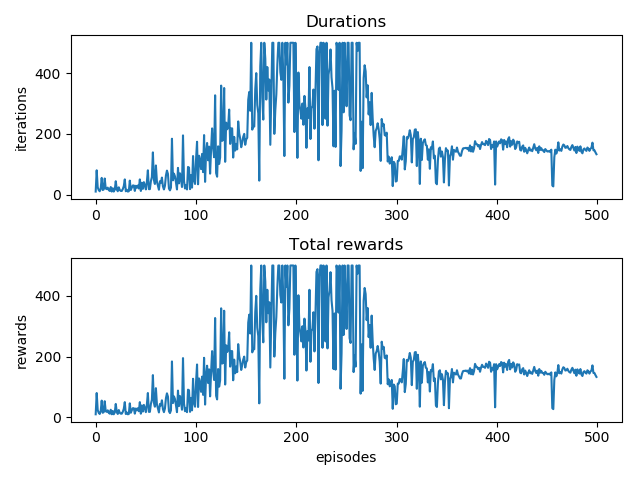

In [22]:
plot_rewards(durations, total_rewards)

## Actor-critic

Actor-critic is an on-policy method similar to REINFORCE. Rather than simply relying on a policy function (actor) to estimate actions, it also consists of a value function (critic) — which can be either a state-value function, $V(S)$, or an action-value function, $Q(S, A)$ — to assist the policy update by reducing gradient variance.

Note that actor-critic is quite similar to REINFORCE with baseline (check [this article](https://www.quora.com/What-is-the-difference-between-policy-gradient-methods-and-actor-critic-methods) for a more detailed explanation), where a baseline can be some stationary values that are not affected by further experience, subtracted from the expected return; in cases where the baseline is a learned value from experience, it simply becomes a 'critic', leaving very little distinction with actor-critic methods.

In [25]:
class ActorCritic(nn.Module):
    def __init__(self, observation_space, action_space):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(observation_space.shape[0], 128)
        self.actor = nn.Linear(128, action_space.n)
        self.critic = nn.Linear(128, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x), inplace=True)
        return self.actor(x), self.critic(x)
    
    def act(self, observation, deterministic=False):
        if deterministic:
            with torch.no_grad():
                logit, _ = self.forward(observation)
                act_prob = F.softmax(logit, dim=-1)
                return act_prob.argmax(dim=1, keepdim=True).item()
        
        # for training
        logit, val_pred = self.forward(observation)
        act_prob = F.softmax(logit, dim=-1)
        dist = distributions.Categorical(act_prob)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action.item(), log_prob, val_pred

In [26]:
summary(ActorCritic(env.observation_space, env.action_space).to(device), (env.observation_space.shape[0],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]             640
            Linear-2                    [-1, 2]             258
            Linear-3                    [-1, 1]             129
Total params: 1,027
Trainable params: 1,027
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [36]:
def actor_critic(env, agent, alpha, gamma, max_episode_steps, n_eps, device):
    agent = agent.to(device)
    optimizer = optim.Adam(agent.parameters(), lr=alpha)
    
    ep_log = []
    for ep in tqdm(range(n_eps)):
        # rollout storage
        log_probs = []
        val_preds = []
        rewards = []
        gammas = []
        
        # collect data via exploration
        obs = env.reset()
        t = done = 0
        while not done and t < max_episode_steps:
            obs = torch.tensor(obs).float().to(device)
            action, log_prob, val_pred = agent.act(obs)
            obs, reward, done, _ = env.step(action)
            
            log_probs.append(log_prob)
            val_preds.append(val_pred)
            rewards.append(reward)
            gammas.append(gamma ** t)
            t += 1
        
        # compute losses
        log_probs = torch.stack(log_probs)
        val_preds = torch.cat(val_preds)
        returns = expected_returns(rewards, gamma).to(device)
        advantages = returns - val_preds.detach()
        gammas = torch.tensor(gammas).to(device)
        actor_loss = torch.dot(advantages, -log_probs)
        critic_loss = F.mse_loss(val_preds, returns)
        loss = actor_loss + critic_loss
        
        # update agent parameters
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(agent.parameters(), 0.5)
        optimizer.step()
        
        ep_log.append((t, sum(rewards)))
    return ep_log

In [34]:
agent = ActorCritic(env.observation_space, env.action_space)
ep_log = actor_critic(env, agent, 3e-3, 0.99, 500, 500, device)
durations, total_rewards = zip(*ep_log)

<IPython.core.display.Javascript object>


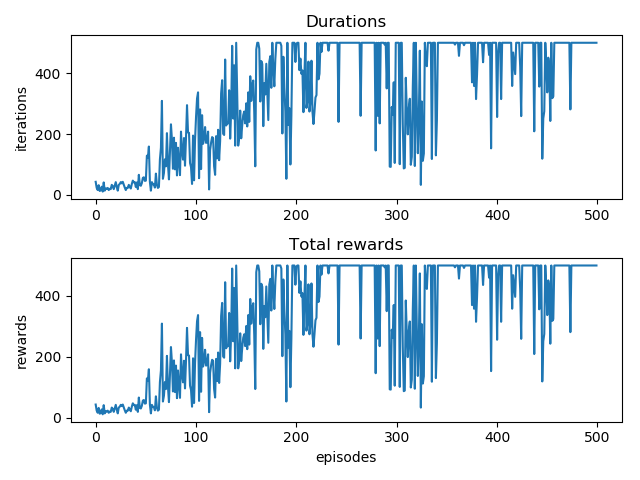

In [35]:
plot_rewards(durations, total_rewards)

## Deep reinforcement learning

In the previous section, we explored some basic (popular) methods of reinforcement learning. In this section, we will look at more advanced and recent algorithms that utilize deep neural networks as a function approximator (hence, deep reinforcement learning).

We will initially follow the curriculum provided by OpenAI's [Spinning Up in Deep RL](https://blog.openai.com/spinning-up-in-deep-rl/). From https://spinningup.openai.com/en/latest/user/algorithms.html,

> ### Why These Algorithms?
> We chose the core deep RL algorithms in this package to reflect useful progressions of ideas from the recent history of the field, culminating in two algorithms in particular—PPO and SAC—which are close to SOTA on reliability and sample efficiency among policy-learning algorithms. They also expose some of the trade-offs that get made in designing and using algorithms in deep RL.

As more and more papers come out in this field, we will also gradually expand this notebook.

### Trust-Region Policy Optimization (TRPO)

### Proximal Policy Optimization (PPO)

### Deep Deterministic Policy Gradient (DDPG)

### Twin Delayed DDPG (TD3)

### Soft Actor-Critic (SAC)

## References